# Fast Style Transfer: Training a Feedforward Network for Artistic Style

Welcome to the second part of our journey into neural style transfer, where we delve into the exciting realm of Fast Style Transfer. If you haven't already, I recommend checking out the [previous post](#) for a comprehensive foundation on style transfer concepts.

## The Need for Speed

In the traditional Gatys style transfer approach, the optimization process for generating a styled image is iterative and time-consuming. Real-time applications or styling videos using this method is a formidable challenge.

Fast Style Transfer presents a solution by employing a feedforward network. Instead of iterative optimization, we train this network to learn the mapping between input images and their stylized counterparts. The result? A model that can generate infinite styled images quickly and efficiently.

### Training Insights

1. **Feedforward Network:**
   We use a residual autoencoder network, the same one employed in the original implementation. This network takes a content image as input and produces a stylized image.

2. **Loss Function:**
   The loss function, as defined in the Gatys et al. paper, remains crucial. It comprises both style and content loss. Refer to the [previous post](#) for a detailed explanation.

3. **Normalization Technique:**
   Instead of batch normalization, we opt for instance normalization, following the findings of the paper titled [Instance Normalization: The Missing Ingredient for Fast Stylization](https://arxiv.org/abs/1607.08022). This choice often yields superior results.

4. **Perceptual Loss:**
   VGG19 comes into play for calculating perceptual loss, a critical aspect discussed in the original paper. This loss is instrumental in ensuring that the generated images capture the style essence effectively.

### Implementation Prerequisites

Before delving into this post, ensure you have a solid understanding of convolutional autoencoders and residual layers (skip connections) in deep learning. These concepts will be applied in our implementation.

Ready to embark on the journey of training a model that unlocks the potential for rapid, on-the-fly artistic style transfer? Let's dive in!

For those eager to get hands-on with video and image style transfer right away, check out the [accompanying GitHub repository](https://github.com/tarun-bisht/fast-style-transfer) with detailed instructions. Happy styling!


### Importing Necessary Modules

Lets start by importing all necessary modules:

- `numpy` : for arrays manipulation
- `tensorflow` : for tensor operations
- `tensorflow.keras` : high level neural network library for tensorflow for creating neural networks
- `pillow` : for converting an image to numpy array and numpy array to image, saving out output image.
- `time` : for calculating time of each iteration
- `matplotlib` : for displaying images and graphs in notebook
- `request`, `base64`, `io` : for downloading and loading image from url
- `os` : operating system level commands

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import load_model,Model
from PIL import Image
import time
import matplotlib.pyplot as plt
import matplotlib
import requests
import base64
import os
from pathlib import Path
from io import BytesIO
matplotlib.rcParams['figure.figsize'] = (12,12)
matplotlib.rcParams['axes.grid'] = False

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Define Utility Functions

In [2]:
def load_image(image_path, dim=None, resize=False):
    img= Image.open(image_path)
    if dim:
        if resize:
            img=img.resize(dim)
        else:
            img.thumbnail(dim)
    img= img.convert("RGB")
    return np.array(img)

The above function is used to load image from path specified and convert it into numpy array

In [3]:
def load_url_image(url,dim=None,resize=False):
    img_request=requests.get(url)
    img= Image.open(BytesIO(img_request.content))
    if dim:
        if resize:
            img=img.resize(dim)
        else:
            img.thumbnail(dim)
    img= img.convert("RGB")
    return np.array(img)

This function loads image from url and convert it into numpy array

In [4]:
def array_to_img(array):
    array=np.array(array,dtype=np.uint8)
    if np.ndim(array)>3:
        assert array.shape[0]==1
        array=array[0]
    return Image.fromarray(array)

In [5]:
def show_image(image,title=None):
    if len(image.shape)>3:
        image=tf.squeeze(image,axis=0)
    plt.imshow(image)
    if title:
        plt.title=title

In [6]:
def plot_images_grid(images,num_rows=1):
    n=len(images)
    if n > 1:
        num_cols=np.ceil(n/num_rows)
        fig,axes=plt.subplots(ncols=int(num_cols),nrows=int(num_rows))
        axes=axes.flatten()
        fig.set_size_inches((15,15))
        for i,image in enumerate(images):
            axes[i].imshow(image)
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(images[0])

Above three functions are used for converting and plotting images:
- `array_to_img`: Converts an array to image
- `show_image`: plot single image
- `plot_images_grid`: plots batches of images in grid

### Steps for fast style transfer

The training model is an encoder-decoder architecture with residual layers. Input images are passed to encoder part and it propogates to decoder part. Output is same size as input and spits generated image. 

This model is train on a loss which is called perceptual loss, the loss is calculated in same way as we calculate in gatys style transfer. Using a pretrained model to extract feature maps from style and content layers defined and using them to calculate style loss and content loss. (For more detail read previous post it was explained there)

As part of training the model we need training data, For training model we need a dataset of different images(can be anything like person, dog, car etc..) in bulk. In this post we are using [coco dataset](http://images.cocodataset.org/zips/train2014.zip) which have lots of images. I have also used [kaggle challenge dataset](https://www.kaggle.com/c/gan-getting-started) which has image of different landscapes, you can check code kernel [here](https://www.kaggle.com/tarunbisht11/generate-art-using-fast-style-transfer-in-a-second). We also need a style image whose style we want to learn using autoencoder. We can use any painting or sketch (select one from internet)

For training this model we send batch of input training images of various contents into autoencoder which provides us output this output has to be our styled image, while training we pass these output images batches into our loss model (vgg19) in our case and features from different layers were extracted (content layers and style layers) these features are then used to calculate style loss and content loss, whose weighted sum produce perceptual loss that trains the network. The below image from paper describe it well.

![https://arxiv.org/abs/1603.08155](https://miro.medium.com/max/1574/1*Um82GJ99gauIOh0U-S11hQ.png)

After training we can use that network for styling any image in one pass without need of optimization

The main highlights of network:
- Residual Layers
- Encoder Decoder Model
- output from decoder is passed to loss model(VGG) to calculate loss
- training needs compute as we are passing these images to two networks on every step

### Define loss 

For calculating style loss and content loss we need a pretrained model, we are using vgg19 the original implementation uses vgg16.

In [7]:
vgg=vgg19.VGG19(weights='imagenet',include_top=False)
vgg.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

Here we define layers that we will use to calculate loss.

In [8]:
content_layers=['block4_conv2']

style_layers=['block1_conv1',
            'block2_conv1',
            'block3_conv1',
            'block4_conv1',
            'block5_conv1']

Lets define a class that creates loss model with some additional methods for accessing feature maps from network. We have also used these functions in previous post, here we just encapsulated them inside a class.

In [9]:
class LossModel:
    def __init__(self,pretrained_model,content_layers,style_layers):
        self.model=pretrained_model
        self.content_layers=content_layers
        self.style_layers=style_layers
        self.loss_model=self.get_model()

    def get_model(self):
        self.model.trainable=False
        layer_names=self.style_layers + self.content_layers
        outputs=[self.model.get_layer(name).output for name in layer_names]
        new_model=Model(inputs=self.model.input,outputs=outputs)
        return new_model
    
    def get_activations(self,inputs):
        inputs=inputs*255.0
        style_length=len(self.style_layers)
        outputs=self.loss_model(vgg19.preprocess_input(inputs))
        style_output,content_output=outputs[:style_length],outputs[style_length:]
        content_dict={name:value for name,value in zip(self.content_layers,content_output)}
        style_dict={name:value for name,value in zip(self.style_layers,style_output)}
        return {'content':content_dict,'style':style_dict}

Now we create our loss model using above class

In [10]:
loss_model = LossModel(vgg, content_layers, style_layers)

Lets define loss function for calculating content and style loss, below methods `content_loss` and `style _loss` calculates content and style loss respectively. With weighted averaging of these losses we derive perceptual loss defined in `preceptual_loss` function. The details of these loss functions are covered in previous post.

In [11]:
def content_loss(placeholder,content,weight):
    assert placeholder.shape == content.shape
    return weight*tf.reduce_mean(tf.square(placeholder-content))

In [12]:
def gram_matrix(x):
    gram=tf.linalg.einsum('bijc,bijd->bcd', x, x)
    return gram/tf.cast(x.shape[1]*x.shape[2]*x.shape[3],tf.float32)

In [13]:
def style_loss(placeholder,style, weight):
    assert placeholder.shape == style.shape
    s=gram_matrix(style)
    p=gram_matrix(placeholder)
    return weight*tf.reduce_mean(tf.square(s-p))

In [14]:
def preceptual_loss(predicted_activations,content_activations,
                    style_activations,content_weight,style_weight,
                    content_layers_weights,style_layer_weights):
    pred_content = predicted_activations["content"]
    pred_style = predicted_activations["style"]
    c_loss = tf.add_n([content_loss(pred_content[name],content_activations[name],
                                  content_layers_weights[i]) for i,name in enumerate(pred_content.keys())])
    c_loss = c_loss*content_weight
    s_loss = tf.add_n([style_loss(pred_style[name],style_activations[name],
                                style_layer_weights[i]) for i,name in enumerate(pred_style.keys())])
    s_loss = s_loss*style_weight
    return c_loss+s_loss

### Create Autoencoder

Here we first defined all necessary layers for our network:

- `ReflectionPadding2D` : for applying reflection padding to images in conv nets
- `InstanceNormalization` : We are using instance normalization instead of batch normalization as it gives better result. It normalize inputs across channel.
- `ConvLayer` : Block of conv layer with padding-> conv_layer-> instance_normalization combined
- `ResidualLayer` : Residual layer with two ConvLayer block
- `UpsampleLayer` : upsample the bottleneck representation (if you have read about autoencoders you know what I mean) in autoencoder. It can be considered as deconvolutional layers.

In [15]:
class ReflectionPadding2D(tf.keras.layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.padding = tuple(padding)
    def call(self, input_tensor):
        padding_width, padding_height = self.padding
        return tf.pad(input_tensor, [[0,0], [padding_height, padding_height], 
                                     [padding_width, padding_width], [0,0] ], 'REFLECT')

In [16]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
    def call(self,inputs):
        batch, rows, cols, channels = [i for i in inputs.get_shape()]
        mu, var = tf.nn.moments(inputs, [1,2], keepdims=True)
        shift = tf.Variable(tf.zeros([channels]))
        scale = tf.Variable(tf.ones([channels]))
        epsilon = 1e-3
        normalized = (inputs-mu)/tf.sqrt(var + epsilon)
        return scale * normalized + shift

In [17]:
class ConvLayer(tf.keras.layers.Layer):
    def __init__(self,filters,kernel_size,strides=1,**kwargs):
        super(ConvLayer,self).__init__(**kwargs)
        self.padding=ReflectionPadding2D([k//2 for k in kernel_size])
        self.conv2d=tf.keras.layers.Conv2D(filters,kernel_size,strides)
        self.bn=InstanceNormalization()
    def call(self,inputs):
        x=self.padding(inputs)
        x=self.conv2d(x)
        x=self.bn(x)
        return x

In [18]:
class ResidualLayer(tf.keras.layers.Layer):
    def __init__(self,filters,kernel_size,**kwargs):
        super(ResidualLayer,self).__init__(**kwargs)
        self.conv2d_1=ConvLayer(filters,kernel_size)
        self.conv2d_2=ConvLayer(filters,kernel_size)
        self.relu=tf.keras.layers.ReLU()
        self.add=tf.keras.layers.Add()
    def call(self,inputs):
        residual=inputs
        x=self.conv2d_1(inputs)
        x=self.relu(x)
        x=self.conv2d_2(x)
        x=self.add([x,residual])
        return x

In [19]:
class UpsampleLayer(tf.keras.layers.Layer):
    def __init__(self,filters,kernel_size,strides=1,upsample=2,**kwargs):
        super(UpsampleLayer,self).__init__(**kwargs)
        self.upsample=tf.keras.layers.UpSampling2D(size=upsample)
        self.padding=ReflectionPadding2D([k//2 for k in kernel_size])
        self.conv2d=tf.keras.layers.Conv2D(filters,kernel_size,strides)
        self.bn=InstanceNormalization()
    def call(self,inputs):
        x=self.upsample(inputs)
        x=self.padding(x)
        x=self.conv2d(x)
        return self.bn(x)

Using these layers defined above lets create an convolutional autoencoder.

Architecture:

- 3 ConvLayer
- 5 ResidualLayer
- 3 UpsampleLayer

In [20]:
class StyleTransferModel(tf.keras.Model):
    def __init__(self,**kwargs):
        super(StyleTransferModel, self).__init__(name='StyleTransferModel',**kwargs)
        self.conv2d_1= ConvLayer(filters=32,kernel_size=(9,9),strides=1,name="conv2d_1_32")
        self.conv2d_2= ConvLayer(filters=64,kernel_size=(3,3),strides=2,name="conv2d_2_64")
        self.conv2d_3= ConvLayer(filters=128,kernel_size=(3,3),strides=2,name="conv2d_3_128")
        self.res_1=ResidualLayer(filters=128,kernel_size=(3,3),name="res_1_128")
        self.res_2=ResidualLayer(filters=128,kernel_size=(3,3),name="res_2_128")
        self.res_3=ResidualLayer(filters=128,kernel_size=(3,3),name="res_3_128")
        self.res_4=ResidualLayer(filters=128,kernel_size=(3,3),name="res_4_128")
        self.res_5=ResidualLayer(filters=128,kernel_size=(3,3),name="res_5_128")
        self.deconv2d_1= UpsampleLayer(filters=64,kernel_size=(3,3),name="deconv2d_1_64")
        self.deconv2d_2= UpsampleLayer(filters=32,kernel_size=(3,3),name="deconv2d_2_32")
        self.deconv2d_3= ConvLayer(filters=3,kernel_size=(9,9),strides=1,name="deconv2d_3_3")
        self.relu=tf.keras.layers.ReLU()
    def call(self, inputs):
        x=self.conv2d_1(inputs)
        x=self.relu(x)
        x=self.conv2d_2(x)
        x=self.relu(x)
        x=self.conv2d_3(x)
        x=self.relu(x)
        x=self.res_1(x)
        x=self.res_2(x)
        x=self.res_3(x)
        x=self.res_4(x)
        x=self.res_5(x)
        x=self.deconv2d_1(x)
        x=self.relu(x)
        x=self.deconv2d_2(x)
        x=self.relu(x)
        x=self.deconv2d_3(x)
        x = (tf.nn.tanh(x) + 1) * (255.0 / 2)
        return x
    
    ## used to print shapes of each layer to check if input shape == output shape
    ## I don't know any better solution to this right now
    def print_shape(self,inputs):
        print(inputs.shape)
        x=self.conv2d_1(inputs)
        print(x.shape)
        x=self.relu(x)
        x=self.conv2d_2(x)
        print(x.shape)
        x=self.relu(x)
        x=self.conv2d_3(x)
        print(x.shape)
        x=self.relu(x)
        x=self.res_1(x)
        print(x.shape)
        x=self.res_2(x)
        print(x.shape)
        x=self.res_3(x)
        print(x.shape)
        x=self.res_4(x)
        print(x.shape)
        x=self.res_5(x)
        print(x.shape)
        x=self.deconv2d_1(x)
        print(x.shape)
        x=self.relu(x)
        x=self.deconv2d_2(x)
        print(x.shape)
        x=self.relu(x)
        x=self.deconv2d_3(x)
        print(x.shape)

define input shape and batch_size here

In [21]:
input_shape=(256,256,3)
batch_size=4

Create style model using `StyleTransferModel` class

In [22]:
style_model = StyleTransferModel()

Here we check shape of all layers and verify input shape and output shape

In [23]:
style_model.print_shape(tf.zeros(shape=(1,*input_shape)))

(1, 256, 256, 3)
(1, 256, 256, 32)
(1, 128, 128, 64)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 128, 128, 64)
(1, 256, 256, 32)
(1, 256, 256, 3)


### Training model

Here we have defined an optimizer for training, we are using Adam optimizer with learning rate 1e-3

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [66]:
def train_step(dataset,style_activations,steps_per_epoch,style_model,loss_model,optimizer,
               checkpoint_path="./",content_weight=1e4, style_weight=1e-2,
               total_variation_weight=0.004,content_layers_weights=[1],style_layers_weights=[1] * 5):
    batch_losses=[]
    steps=1
    save_path=os.path.join(checkpoint_path,f"model_checkpoint.ckpt")
    print("Model Checkpoint Path: ",save_path)
    for input_image_batch in dataset:
        if steps-1 >= steps_per_epoch:
            break
        with tf.GradientTape() as tape:
            outputs=style_model(input_image_batch)
            outputs=tf.clip_by_value(outputs, 0, 255)
            pred_activations=loss_model.get_activations(outputs/255.0)
            content_activations=loss_model.get_activations(input_image_batch)["content"] 
            curr_loss=preceptual_loss(pred_activations,content_activations,style_activations,content_weight,
                                      style_weight,content_layers_weights,style_layers_weights)
            curr_loss += total_variation_weight*tf.image.total_variation(outputs)
        batch_losses.append(curr_loss)
        grad = tape.gradient(curr_loss,style_model.trainable_variables)
        optimizer.apply_gradients(zip(grad,style_model.trainable_variables))
        if steps % 1000==0:
            print("checkpoint saved ",end=" ")
            style_model.save_weights(save_path)
            print(f"Loss: {tf.reduce_mean(batch_losses).numpy()}")
        steps+=1
    return tf.reduce_mean(batch_losses)

In above function we have defined single training step. Inside the function:

- first we defined save_path for model checkpointing
- for number of steps_per_epoch we run a training loop
- for every step we forward pass batch of image pass it to our loss model 
- get content_layer activations for the batch of images
- together with style activations from style image and content activations we calculate perceptual loss
- we add some total variation loss to image for smoothening
- calculate gradients of loss function with respect to model trainable parameters
- finally backpropogates to optimize
- at every 1000 steps saving checkpoints

### Configure Dataset for training

Monunting google drive for saving checkpoints

Downloading coco dataset for training images,  we can use any other image dataset with images in bulk

In [67]:
# !wget http://images.cocodataset.org/zips/train2014.zip

unzipping zip file and removing it after unzipping to get some more free space

In [68]:
# !mkdir coco
# !unzip -qq train2014.zip -d coco

In [69]:
# !rm train2014.zip

For training model lets create tensorflow dataset which loads all images from path specified resize them to be of same size for efficient batch training and implements batching and prefetching. Below class creates tfdataset for training. 

Note we are training model with fixed size images but we can generate image of any size because all layers in model are convolutional layers. 

In [70]:
class TensorflowDatasetLoader:
    def __init__(self,dataset_path,batch_size=4, image_size=(256, 256),num_images=None):
        images_paths = [str(path) for path in Path(dataset_path).glob("*.jpg")]
        self.length=len(images_paths)
        if num_images is not None:
            images_paths = images_paths[0:num_images]
        dataset = tf.data.Dataset.from_tensor_slices(images_paths).map(
            lambda path: self.load_tf_image(path, dim=image_size),
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
        dataset = dataset.batch(batch_size,drop_remainder=True)
        dataset = dataset.repeat()
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        self.dataset=dataset
    def __len__(self):
        return self.length
    def load_tf_image(self,image_path,dim):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image= tf.image.resize(image,dim)
        image= image/255.0
        image = tf.image.convert_image_dtype(image, tf.float32)
        return image

using above class lets create tfdataset from coco dataset images. Specify path to images folder and batch size

In [71]:
loader=TensorflowDatasetLoader("/kaggle/input/landscape-pictures",batch_size=4)

In [72]:
loader.dataset.element_spec

TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float32, name=None)

plot some images to see how images in dataset looks

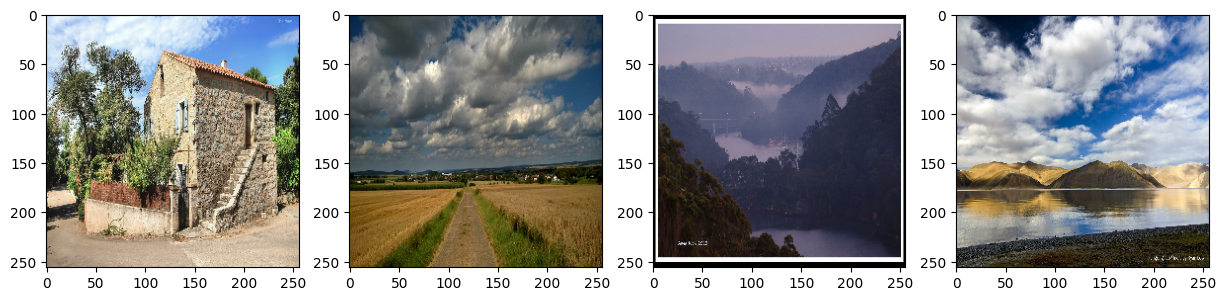

In [73]:
plot_images_grid(next(iter(loader.dataset.take(1))))

Now lets load style image from url using `load_url_image` and plot it.

In [74]:
# setting up style image
url="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/300px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"
style_image=load_url_image(url,dim=(input_shape[0],input_shape[1]),resize=True)
style_image=style_image/255.0

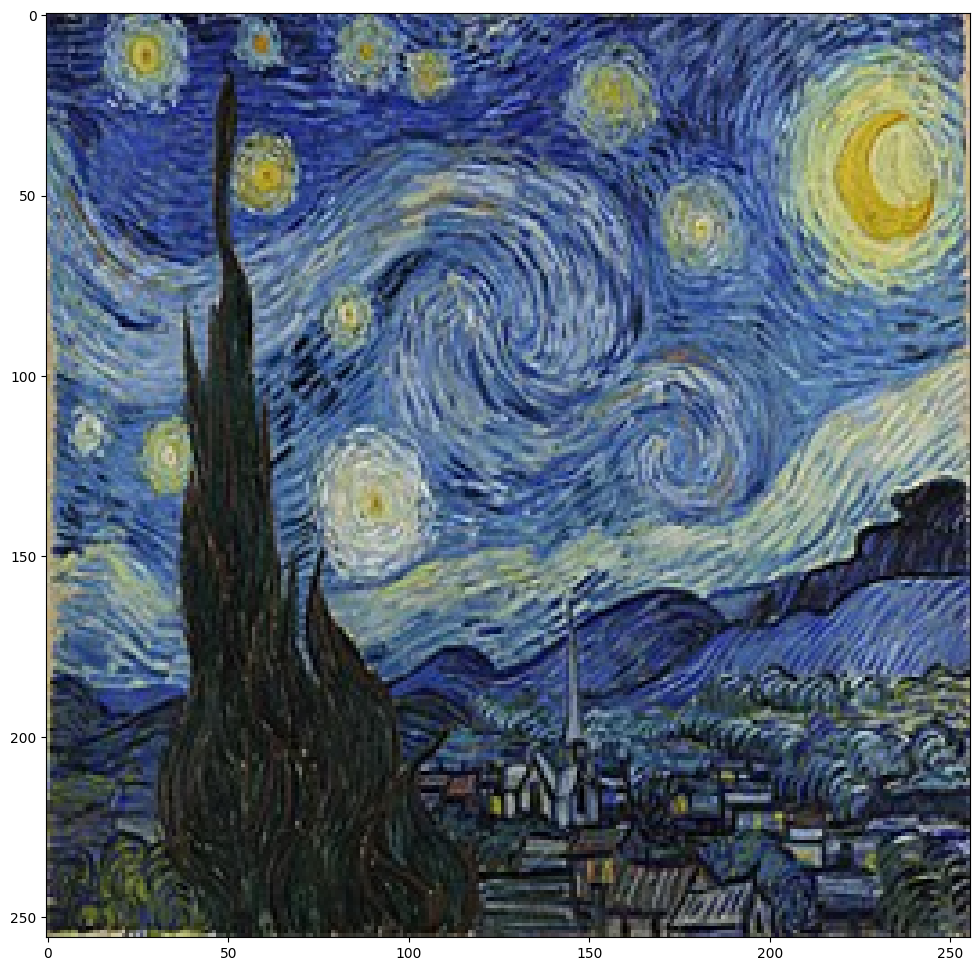

In [75]:
show_image(style_image)

Next we extract style layers feature maps of style image using loss model

In [76]:
style_image=style_image.astype(np.float32)
style_image_batch=np.repeat([style_image],batch_size,axis=0)
style_activations=loss_model.get_activations(style_image_batch)["style"]

### Training model

define content weight, style weight and total variation weight these are hyperparmeters which we can tune to change strength of style and content in output image

In [77]:
content_weight=1e1
style_weight=1e2
total_variation_weight=0.004

Now define number of epochs to train, steps per epochs and model checkpoint path

In [78]:
epochs=2

In [79]:
num_images=len(loader)
steps_per_epochs=num_images//batch_size
print(steps_per_epochs)

1079


In [91]:
model_save_path="/kaggle/working/"
top_folder_name="scream"
save_path=os.path.join(model_save_path,top_folder_name)
print(save_path)

/kaggle/working/scream


In [92]:
os.makedirs(os.path.join(model_save_path,top_folder_name),exist_ok=True)

Enable mixed precision training it offers significant computational speedup by performing operations in half-precision format.

In [93]:
try:
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.keras.mixed_precision.experimental.set_policy(policy) 
except:
    pass

if previous checkpoint exist at that path load that checkpoint and continue further training else we train from scratch

In [94]:
if os.path.isfile(os.path.join(save_path,"model_checkpoint.ckpt.index")):
    style_model.load_weights(os.path.join(save_path,"model_checkpoint.ckpt"))
    print("resuming training ...")
else:
    print("training scratch ...")

training scratch ...


Finally we start training model. At each epoch we are calling `train_step` function which runs till number of steps er epochs defined and after every epoch save model checkpoint for further inferencing and training

In [95]:
epoch_losses=[]
for epoch in range(1,epochs+1):
    print(f"epoch: {epoch}")
    batch_loss=train_step(loader.dataset,style_activations,steps_per_epochs,style_model,loss_model,optimizer,
                          save_path,
                          content_weight,style_weight,total_variation_weight)
    style_model.save_weights(os.path.join(save_path,"model_checkpoint.ckpt"))
    print("Model Checkpointed at: ",os.path.join(save_path,"model_checkpoint.ckpt"))
    print(f"loss: {batch_loss.numpy()}")
    epoch_losses.append(batch_loss)

epoch: 1
Model Checkpoint Path:  /kaggle/working/scream/model_checkpoint.ckpt
checkpoint saved  Loss: 12487161.0
Model Checkpointed at:  /kaggle/working/scream/model_checkpoint.ckpt
loss: 12314819.0
epoch: 2
Model Checkpoint Path:  /kaggle/working/scream/model_checkpoint.ckpt
checkpoint saved  Loss: 9293294.0
Model Checkpointed at:  /kaggle/working/scream/model_checkpoint.ckpt
loss: 9276114.0


After training model lets plot loss with respect to epochs and check loss summary

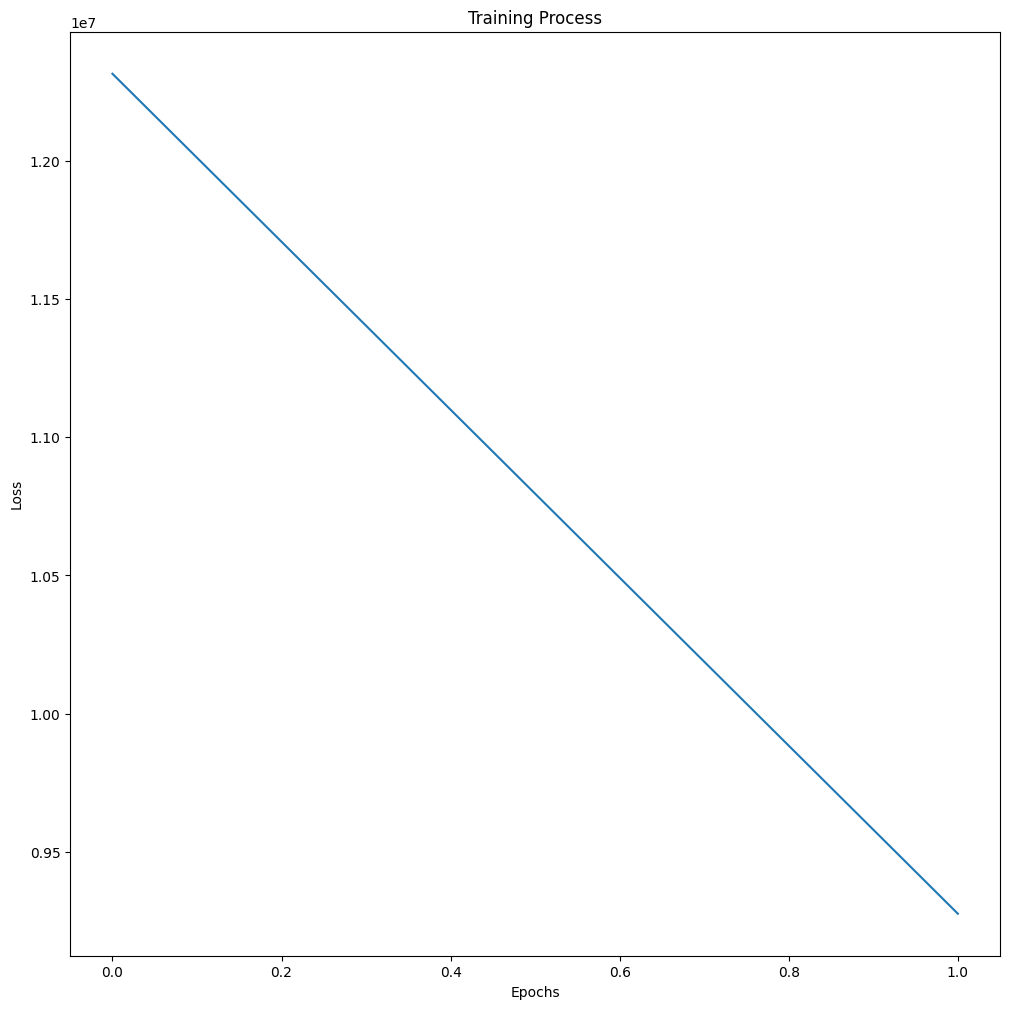

In [96]:
plt.plot(epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Process")
plt.show()

Now its time to generate some style images. We start first by loading saved model checkpoint into autoencoder.

In [97]:
if os.path.isfile(os.path.join(save_path,"model_checkpoint.ckpt.index")):
    style_model.load_weights(os.path.join(save_path,"model_checkpoint.ckpt"))
    print("loading weights ...")
else:
    print("no weights found ...")

loading weights ...


In [124]:
# Function to test multiple images
def test_images(image_urls, style_model, dim=(640, 480)):
    for url in image_urls:
        # Load and preprocess the test image
        test_image = Image.open(url)
        test_image=np.expand_dims(test_image,axis=0)
        test_image=test_image.astype(np.float32)

        # Apply the style model
        predicted_image = style_model(test_image)
    
        # Convert test image and predicted image to uint8 for visualization
        test_output = test_image.astype(np.uint8)
        predicted_image=np.clip(predicted_image,0,255)
        predicted_image = predicted_image.astype(np.uint8)
        test_output=tf.squeeze(test_output).numpy()
        predicted_output=tf.squeeze(predicted_image).numpy()

        # Plot the original and styled images
        plot_images_grid([test_output, predicted_output])

        # Save the styled image
        styled_image_pil = Image.fromarray(predicted_output)
        styled_image_pil.save('styled_image_{}.jpg'.format(image_urls.index(url)))

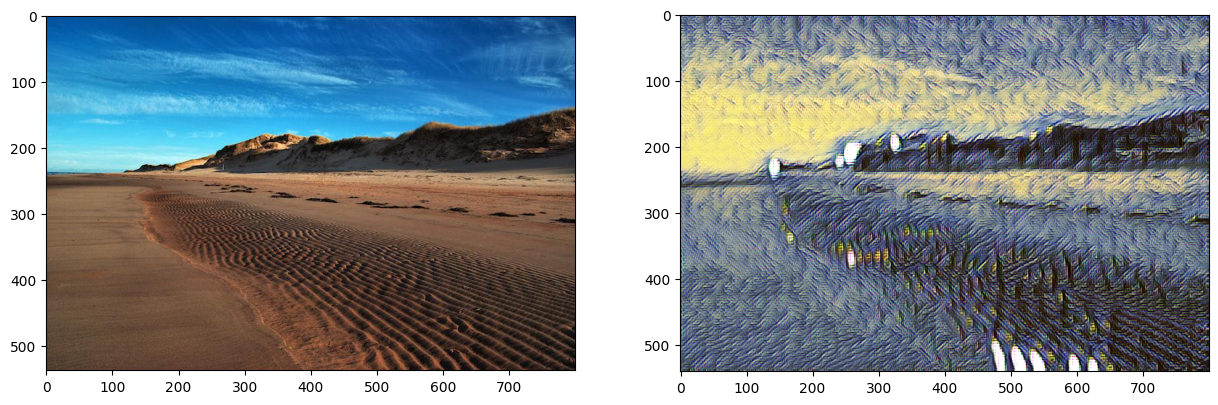

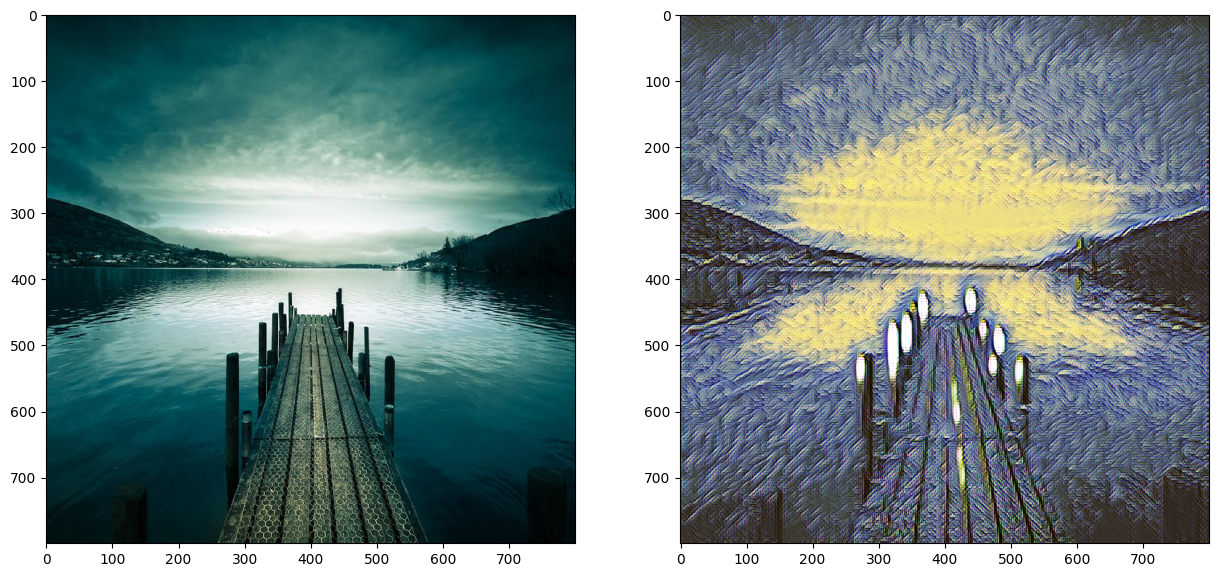

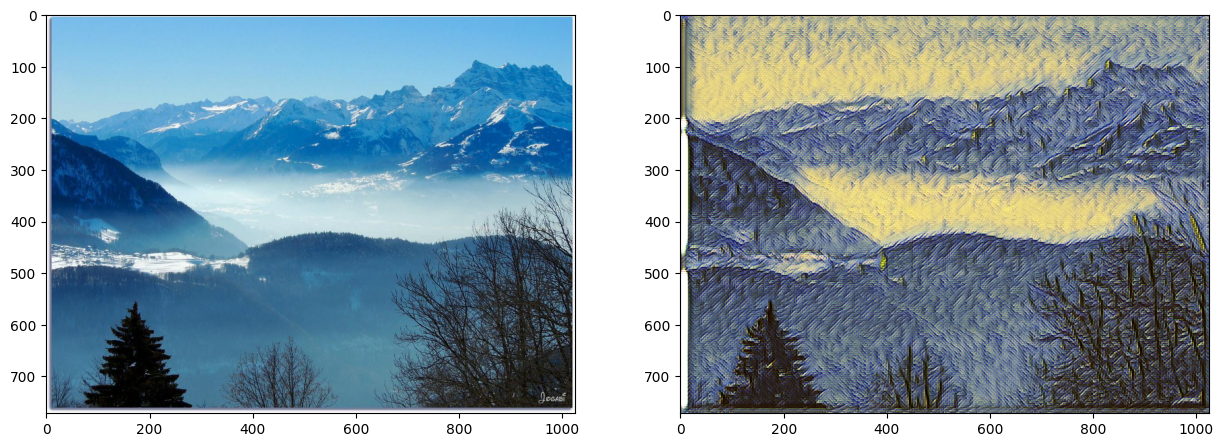

In [127]:
test_image_urls=["/kaggle/input/landscape-pictures/00000002_(4).jpg","/kaggle/input/landscape-pictures/00000000_(2).jpg","/kaggle/input/landscape-pictures/00000000_(3).jpg"]
test_images(test_image_urls,style_model)

load an image for styling and convert it to float.

In [98]:
test_image_url="https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/chicago-skyline-on-a-clear-day-royalty-free-image-115891582-1557159569.jpg"

In [99]:
test_image=load_url_image(test_image_url,dim=(640,480))
test_image=np.expand_dims(test_image,axis=0)

In [100]:
test_image=test_image.astype(np.float32)

In one forward pass of model we get generated styled image 

In [101]:
predicted_image=style_model(test_image)

Clamp generated image pixels between 0 to 255 and convert it to uint8. We got our generated style image, plot it and check how its looks also save it and share with friends

In [102]:
predicted_image=np.clip(predicted_image,0,255)
predicted_image=predicted_image.astype(np.uint8)

In [103]:
test_output=test_image.astype(np.uint8)
test_output=tf.squeeze(test_output).numpy()
predicted_output=tf.squeeze(predicted_image).numpy()

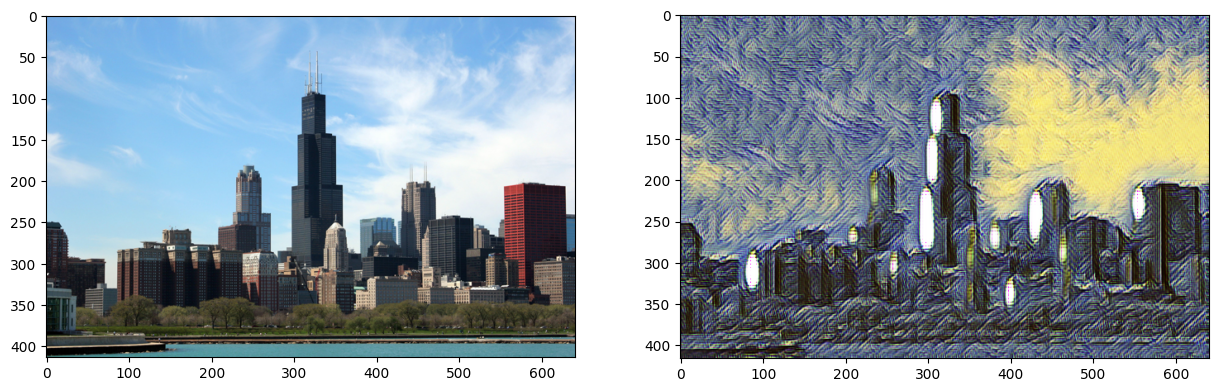

In [104]:
plot_images_grid([test_output,predicted_output])

### Results
Some Image results

![jpg](js_candy.jpg)

![jpg](heather-gill-7Frxnyv7Ntg-unsplash-udine.jpg)

![jpg](kido.jpg)

![jpg](styled_candy.jpg)

Here we have realtime video stylization in action

<img src='https://github.com/tarun-bisht/fast-style-transfer/raw/master/output/webcam.gif' alt="webcam output">

Below is youtube video for video stylization in action


<div style="margin:1rem 0;">
  <a href="http://www.youtube.com/watch?v=GrS4rWifdko"><img src='https://github.com/tarun-bisht/fast-style-transfer/raw/master/output/video.gif' alt="Pithoragarh style transfer"></a>
</div>

Now generate different images and videos, play with it and share exciting results.

Thanks for reading till last. ✌✌✌

### References

- [Instance Normalization: The Missing Ingredient for Fast Stylization](https://arxiv.org/abs/1607.08022)
- [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155)
- [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)

### Important links

- [github repository](https://github.com/tarun-bisht/fast-style-transfer)
- [google colab notebook link](https://github.com/tarun-bisht/blogs-notebooks/blob/master/style-transfer/Neural%20Style%20Transfer%20Part%202.ipynb)